# Calculate Component Interfaces

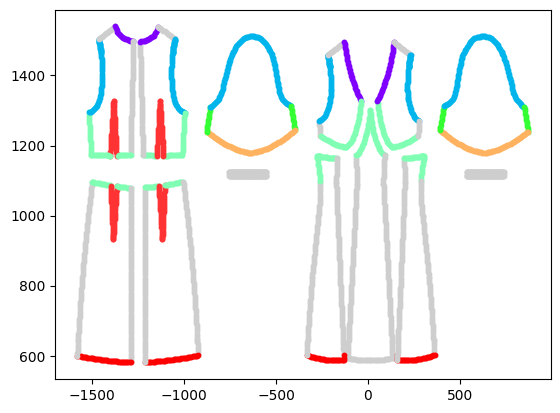

{'panel_id': '89ae5925-a820-479c-abaf-4429931639a1', 'edge_id': '63d8f83a-1988-4355-ba05-4f2609f9a5a0', 'edge_param': 0.04, 'panel_label': '衣身前中', 'edge_label': '腰线'}


In [15]:
import os
import sys
import json

import numpy as np
import igl
from geomdl import fitting, BSpline, utilities

from matplotlib import pyplot as plt

sys.path.insert(0, os.path.abspath('..'))

from data_process.geometry_utils.obj import read_obj

_CMAP = {
    "帽": {"alias": "帽", "color": "#F7815D"},
    "领": {"alias": "领", "color": "#F9D26D"},
    "肩": {"alias": "肩", "color": "#F23434"},
    "袖片": {"alias": "袖片", "color": "#C4DBBE"},
    "袖口": {"alias": "袖口", "color": "#F0EDA8"},
    "衣身前中": {"alias": "衣身前中", "color": "#8CA740"},
    "衣身后中": {"alias": "衣身后中", "color": "#4087A7"},
    "衣身侧": {"alias": "衣身侧", "color": "#DF7D7E"},
    "底摆": {"alias": "底摆", "color": "#DACBBD"},
    "腰头": {"alias": "腰头", "color": "#DABDD1"},
    "裙前中": {"alias": "裙前中", "color": "#46B974"},
    "裙后中": {"alias": "裙后中", "color": "#6B68F5"},
    "裙侧": {"alias": "裙侧", "color": "#D37F50"},

    "橡筋": {"alias": "橡筋", "color": "#696969"},
    "木耳边": {"alias": "木耳边", "color": "#A8D4D2"},
    "袖笼拼条": {"alias": "袖笼拼条", "color": "#696969"},
    "荷叶边": {"alias": "荷叶边", "color": "#A8D4D2"},
    "绑带": {"alias": "绑带", "color": "#696969"},
}

_CMAP_LINE = {
    "领窝线": {"alias": "领窝线", "color": "#8000FF"},          
    "袖笼弧线": {"alias": "袖笼弧线", "color": "#00B5EB"},      # interfaces between sleeve panels and bodice panels (belongs to bodice panels)
    "袖山弧线": {"alias": "袖山弧线", "color": "#00B5EB"},      # interfaces between sleeve panels and bodice panels (belongs to sleeve panels)
    "腰线": {"alias": "腰线", "color": "#80FFB4"},
    "袖口线": {"alias": "袖口线", "color": "#FFB360"},
    "底摆线": {"alias": "底摆线", "color": "#FF0000"},
    
    "省": {"alias": "省道", "color": "#FF3333"},
    "褶": {"alias": "褶", "color": "#33FF33"},
}

_PANEL_CLS = [
    '帽', '领', '肩', '袖片', '袖口', '衣身前中', '衣身后中', '衣身侧', '底摆', '腰头', 
    '裙前中', '裙后中', '裙侧', '橡筋', '木耳边', '袖笼拼条', '荷叶边', '绑带']

_EPS = 1e-2


def _identify_waistline(pattern_spec):
    panel_dict = dict([(x['id'], idx) for (idx, x) in enumerate(pattern_spec['panels'])])
    edge_dict = dict([(edge['id'], (p_idx, s_idx, e_idx)) for p_idx, panel in enumerate(pattern_spec['panels']) \
        for s_idx, seq_edge in enumerate(panel['seqEdges']) for e_idx, edge in enumerate(seq_edge['edges'])])
    
    def _is_upper_bodice(panel_label):
        return panel_label in ['衣身前中', '衣身后中', '衣身侧']
    
    def _is_lower_bodice(panel_label):
        return panel_label in ['裙前中', '裙后中', '裙侧']
    
    def _is_waist(panel_label): return panel_label in ['腰头']
    
    # label stitches
    for idx, stitch in enumerate(pattern_spec['stitches']):
        start_line, end_line = stitch[0], stitch[1]
        
        # skip stitches across different panels
        if start_line["start"]["clothPieceId"] != start_line["end"]["clothPieceId"]: continue
        if end_line["start"]["clothPieceId"] != end_line["end"]["clothPieceId"]: continue
        
        start_panel_idx = panel_dict[start_line["start"]["clothPieceId"]]
        end_panel_idx = panel_dict[end_line["start"]["clothPieceId"]]
        
        start_panel = pattern_spec["panels"][start_panel_idx]
        end_panel = pattern_spec["panels"][end_panel_idx]
        
        if  (_is_upper_bodice(start_panel["label"]) and (_is_lower_bodice(end_panel["label"]) or _is_waist(end_panel["label"]))) or \
            (_is_lower_bodice(start_panel["label"]) and (_is_upper_bodice(end_panel["label"]) or _is_waist(end_panel["label"]))) or \
            (_is_waist(start_panel["label"]) and (_is_upper_bodice(end_panel["label"]) or _is_lower_bodice(end_panel["label"]))):
                
                panel_idx, seg_edge_idx, edge_idx = edge_dict[start_line["start"]["edgeId"]]
                if pattern_spec["panels"][panel_idx]["seqEdges"][seg_edge_idx]["edges"][edge_idx]["label"] not in _CMAP_LINE.keys():
                    pattern_spec["panels"][panel_idx]["seqEdges"][seg_edge_idx]["edges"][edge_idx]["label"] = "腰线"
                
                panel_idx, seg_edge_idx, edge_idx = edge_dict[start_line["end"]["edgeId"]]
                if pattern_spec["panels"][panel_idx]["seqEdges"][seg_edge_idx]["edges"][edge_idx]["label"] not in _CMAP_LINE.keys():
                    pattern_spec["panels"][panel_idx]["seqEdges"][seg_edge_idx]["edges"][edge_idx]["label"] = "腰线"
                
                panel_idx, seg_edge_idx, edge_idx = edge_dict[end_line["start"]["edgeId"]]
                if pattern_spec["panels"][panel_idx]["seqEdges"][seg_edge_idx]["edges"][edge_idx]["label"] not in _CMAP_LINE.keys():
                    pattern_spec["panels"][panel_idx]["seqEdges"][seg_edge_idx]["edges"][edge_idx]["label"] = "腰线"
                
                panel_idx, seg_edge_idx, edge_idx = edge_dict[end_line["end"]["edgeId"]]
                if pattern_spec["panels"][panel_idx]["seqEdges"][seg_edge_idx]["edges"][edge_idx]["label"] not in _CMAP_LINE.keys():
                    pattern_spec["panels"][panel_idx]["seqEdges"][seg_edge_idx]["edges"][edge_idx]["label"] = "腰线"
            
    return pattern_spec


def _identify_darts(pattern_spec):
    panel_dict = dict([(x['id'], idx) for (idx, x) in enumerate(pattern_spec['panels'])])
    edge_dict = dict([(edge['id'], (p_idx, s_idx, e_idx)) for p_idx, panel in enumerate(pattern_spec['panels']) \
        for s_idx, seq_edge in enumerate(panel['seqEdges']) for e_idx, edge in enumerate(seq_edge['edges'])])
    
    for idx, stitch in enumerate(pattern_spec['stitches']):
        start_line, end_line = stitch[0], stitch[1]
        
        # skip stitches across different panels
        if start_line["start"]["clothPieceId"] != start_line["end"]["clothPieceId"]: continue
        if end_line["start"]["clothPieceId"] != end_line["end"]["clothPieceId"]: continue
        
        # identify darts where start_line and end_line are both on the same panel and the edges are connected.
        start_panel_id = panel_dict[start_line["start"]["clothPieceId"]]
        end_panel_id = panel_dict[end_line["start"]["clothPieceId"]]
        
        if start_panel_id == end_panel_id:
            _, start_seq_edge_idx, start_edge_idx = edge_dict[start_line["start"]["edgeId"]]
            _, end_seq_edge_idx, end_edge_idx = edge_dict[end_line["start"]["edgeId"]]
            
            if abs(start_edge_idx - end_edge_idx) == 1:
                if pattern_spec['panels'][start_panel_id]['seqEdges'][start_seq_edge_idx]['edges'][start_edge_idx]['label'] not in _CMAP_LINE.keys():
                    pattern_spec['panels'][start_panel_id]['seqEdges'][start_seq_edge_idx]['edges'][start_edge_idx]['label'] = '省'
                if pattern_spec['panels'][end_panel_id]['seqEdges'][end_seq_edge_idx]['edges'][end_edge_idx]['label'] not in _CMAP_LINE.keys():
                    pattern_spec['panels'][end_panel_id]['seqEdges'][end_seq_edge_idx]['edges'][end_edge_idx]['label'] = '省'
            else:
                if pattern_spec['panels'][start_panel_id]['seqEdges'][start_seq_edge_idx]['edges'][start_edge_idx]['label'] not in _CMAP_LINE.keys():
                    pattern_spec['panels'][start_panel_id]['seqEdges'][start_seq_edge_idx]['edges'][start_edge_idx]['label'] = '褶'
                if pattern_spec['panels'][end_panel_id]['seqEdges'][end_seq_edge_idx]['edges'][end_edge_idx]['label'] not in _CMAP_LINE.keys():
                    pattern_spec['panels'][end_panel_id]['seqEdges'][end_seq_edge_idx]['edges'][end_edge_idx]['label'] = '褶'
    
    return pattern_spec    


def _sample_curve_points_2d(edge_spec, num_samples=32):
    bezierPts = np.asarray(edge_spec['bezierPoints'])[:, :2]
    ctrlPts = np.asarray(edge_spec['controlPoints'])[:, :2]

    if np.any(bezierPts) and len(ctrlPts) == 2:
        if not np.any(bezierPts[1]):
            # print('quadratic bezier')
            bezierPts[1] = 2.0 / 3.0 * \
                (bezierPts[0] + ctrlPts[0] - ctrlPts[1])
            bezierPts[0] = 2.0 / 3.0 * bezierPts[0]

        bezierPts = ctrlPts + bezierPts
        curve = BSpline.Curve()
        curve.degree = 3
        curve.ctrlpts = [ctrlPts[0].tolist()] + \
            bezierPts.tolist() + [ctrlPts[1].tolist()]
        curve.knotvector = utilities.generate_knot_vector(
            curve.degree, len(curve.ctrlpts))
        curve.sample_size = num_samples
        curve.evaluate()

        evalpts = np.array(curve.evalpts)

    else:
        if ctrlPts.shape[0] <= 2:
            evalpts = ctrlPts
            t_values = np.linspace(0, 1, num_samples)
            evalpts = np.outer(1 - t_values, evalpts[0]) + np.outer(t_values, evalpts[1])
        else:
            curve = fitting.interpolate_curve(
                ctrlPts.tolist(), degree=2 if ctrlPts.shape[0] < 5 else 3)
            curve.sample_size = num_samples
            curve.evaluate()
            evalpts = np.array(curve.evalpts)

    return evalpts


def project_verts_to_edges(mesh_obj, pattern_spec):
    
    verts = mesh_obj.points
    uv = mesh_obj.point_data['obj:vt']
        
    pattern_spec = _identify_waistline(pattern_spec)        
    pattern_spec = _identify_darts(pattern_spec)
    
    panel_data = dict([(x['id'], x) for x in pattern_spec['panels']])
    
    vert_labels = {}

    for idx, panel_id in enumerate(mesh_obj.field_data['obj:group_tags']):
        if panel_id not in panel_data: continue
        
        panel_faces = mesh_obj.cells[idx].data
        panel_spec = panel_data[panel_id]
        
        panel_center = np.asarray(panel_spec['center'])
        boundary = igl.boundary_facets(panel_faces)
        boundary_verts_idx = np.unique(boundary)
        boundary_verts_uv = uv[boundary_verts_idx, :2] - panel_center[:2]
        
        for seq_edge in panel_spec['seqEdges']:
            if seq_edge['type'] != 3: continue

            for edge in seq_edge['edges']:
                edge_color = _CMAP_LINE[edge['label']]['color'] if edge['label'] in _CMAP_LINE else '#CECECE'
                edge_samples = _sample_curve_points_2d(edge, 100)
                # plt.plot(edge_samples[:, 0] + panel_center[0], edge_samples[:, 1] + panel_center[1], c=edge_color, label=edge['id'])
                
                edge_bbox = np.array([np.min(edge_samples, axis=0)-_EPS, np.max(edge_samples, axis=0)+_EPS])
                
                # verts within the bounding box of the edge
                within_bbox = np.all(
                    (boundary_verts_uv >= edge_bbox[0]) & (boundary_verts_uv <= edge_bbox[1]), axis=1)
                valid_vert_idx = np.where(within_bbox)[0]
                # remove dis-connected vertices
                if valid_vert_idx[1] - valid_vert_idx[0] > 1: valid_vert_idx = valid_vert_idx[1:]
                if valid_vert_idx[-1] - valid_vert_idx[-2] > 1: valid_vert_idx = valid_vert_idx[:-1]
                
                verts_edge_dist = np.linalg.norm(boundary_verts_uv[valid_vert_idx, :][:, None, :] - edge_samples[None, :, :], axis=2)
                verts_params = np.argmin(verts_edge_dist, axis=1)
                
                for iidx, v_idx in enumerate(boundary_verts_idx[valid_vert_idx]):
                    vert_labels[v_idx] = {
                        'panel_id': panel_id,
                        'edge_id': edge['id'],
                        'edge_param': verts_params[iidx] / 100.0,
                        'panel_label': panel_spec['label'],
                        'edge_label': edge['label']
                    }
                
                # edge_id_list[boundary_verts_idx[valid_vert_idx]] = edge['id']
                # edge_param_list[boundary_verts_idx[valid_vert_idx]] = verts_params
                                
                plt.scatter(
                    uv[boundary_verts_idx[valid_vert_idx], 0],
                    uv[boundary_verts_idx[valid_vert_idx], 1],
                    color=edge_color, s=10, marker='o')
                           
    plt.show()
    
    return vert_labels
    
data_item = "..\\resources\\examples\\objs\\0001"
mesh_fp = os.path.join(data_item, os.path.basename(data_item)+'.obj')
pattern_fp = os.path.join(data_item, 'pattern.json')
mesh_obj = read_obj(mesh_fp)
with open(pattern_fp, 'r', encoding='utf-8') as f: pattern_spec = json.load(f)

vert_labels = project_verts_to_edges(mesh_obj, pattern_spec)

print(vert_labels[0])